In [7]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import os

# Carga el parquet del 2016
df = pd.read_parquet("/workspace/ADGE_project/datasets/daily_accidents_2016.parquet")


In [21]:
df.columns

Index(['Date', 'City', 'State', 'Year', 'Daily_Accidents',
       'Avg_Temperature(F)', 'Avg_Wind_Chill(F)', 'Avg_Humidity(%)',
       'Avg_Pressure(in)', 'Avg_Visibility(mi)', 'Avg_Wind_Speed(mph)',
       'Avg_Precipitation(in)'],
      dtype='object')

In [24]:
df.head(5)

,Date,City,State,Year,Daily_Accidents,Avg_Temperature(F),Avg_Wind_Chill(F),Avg_Humidity(%),Avg_Pressure(in),Avg_Visibility(mi),Avg_Wind_Speed(mph),Avg_Precipitation(in)
0,2021-01-01,Airville,PA,2021,1,30.000000,24.000000,72.000000,30.000000,10.00,6.000000,0.000000
1,2021-01-01,Bay Minette,AL,2021,1,68.000000,68.000000,90.000000,29.890000,10.00,6.000000,0.010000
2,2021-01-01,Bloomfield,IN,2021,3,39.333333,35.000000,91.000000,28.893333,1.25,7.333333,0.026667
3,2021-01-01,Caldwell,ID,2021,8,37.000000,32.000000,79.000000,27.710000,10.00,7.000000,0.000000
4,2021-01-01,Clermont,FL,2021,3,69.333333,69.333333,90.333333,30.060000,10.00,6.333333,0.000000


USANDO TODOS LOS AÑOS

In [ ]:
# usando mlflow
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import mlflow
import mlflow.xgboost
import glob
import os

# === MLflow setup ===
mlflow.set_experiment("Accidents_XGBoost_Base")  # Puedes cambiar el nombre del experimento

with mlflow.start_run():
    # === Cargar datos ===
    files = glob.glob("/workspace/ADGE_project/datasets/daily_accidents_*.parquet")
    df = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)

    df_model = df[['Date', 'City', 'State', 'Year', 'Daily_Accidents']].copy()
    df_model['Date'] = pd.to_datetime(df_model['Date'])
    df_model['DayOfWeek'] = df_model['Date'].dt.dayofweek
    df_model['Month'] = df_model['Date'].dt.month
    df_model['Day'] = df_model['Date'].dt.day

    le_city = LabelEncoder()
    df_model['City_enc'] = le_city.fit_transform(df_model['City'])

    le_state = LabelEncoder()
    df_model['State_enc'] = le_state.fit_transform(df_model['State'])

    feature_cols = ['Year', 'DayOfWeek', 'Month', 'Day', 'City_enc', 'State_enc']
    X = df_model[feature_cols]
    y = df_model['Daily_Accidents']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # === Hiperparámetros ===
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': 100,
        'max_depth': 6,
        'learning_rate': 0.1,
        'random_state': 42
    }

    # Log de parámetros
    mlflow.log_params(params)

    # === Modelo ===
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)

    # === Evaluación ===
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Log de métricas
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R²: {r2:.3f}")

    # === Log de artefacto: Feature importance plot ===
    fig, ax = plt.subplots(figsize=(8, 5))
    xgb.plot_importance(model, max_num_features=10, ax=ax)
    plt.tight_layout()
    plot_path = "feature_importance.png"
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)

    # === Log del modelo completo ===
    mlflow.xgboost.log_model(model, "model")

    # Limpieza
    os.remove(plot_path)


2025/06/03 01:59:18 INFO mlflow.tracking.fluent: Experiment with name 'Accidents_XGBoost_With_Climate' does not exist. Creating a new experiment.


Datos cargados: (1508616, 12)
RMSE: 6.882
MAE: 2.167
R²: 0.402


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [01:59:21] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/03 01:59:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


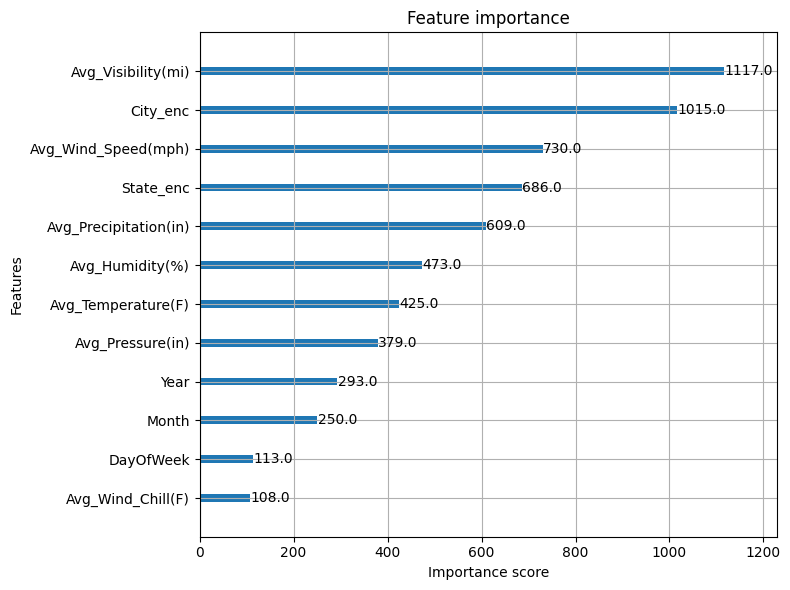

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import glob
import matplotlib.pyplot as plt
import mlflow
import mlflow.xgboost
import os

# === Set experiment ===
mlflow.set_experiment("Accidents_XGBoost_With_Climate")

with mlflow.start_run():
    # === Cargar datos ===
    files = glob.glob("/workspace/ADGE_project/datasets/daily_accidents_*.parquet")
    df = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)

    print(f"Datos cargados: {df.shape}")

    cols = ['Date', 'City', 'State', 'Year', 'Daily_Accidents',
            'Avg_Temperature(F)', 'Avg_Wind_Chill(F)', 'Avg_Humidity(%)',
            'Avg_Pressure(in)', 'Avg_Visibility(mi)', 'Avg_Wind_Speed(mph)', 'Avg_Precipitation(in)']

    df_model = df[cols].copy()

    df_model['Date'] = pd.to_datetime(df_model['Date'])
    df_model['DayOfWeek'] = df_model['Date'].dt.dayofweek
    df_model['Month'] = df_model['Date'].dt.month
    df_model['Day'] = df_model['Date'].dt.day

    le_city = LabelEncoder()
    df_model['City_enc'] = le_city.fit_transform(df_model['City'])

    le_state = LabelEncoder()
    df_model['State_enc'] = le_state.fit_transform(df_model['State'])

    feature_cols = ['Year', 'DayOfWeek', 'Month', 'Day', 'City_enc', 'State_enc',
                    'Avg_Temperature(F)', 'Avg_Wind_Chill(F)', 'Avg_Humidity(%)',
                    'Avg_Pressure(in)', 'Avg_Visibility(mi)', 'Avg_Wind_Speed(mph)', 'Avg_Precipitation(in)']

    X = df_model[feature_cols]
    y = df_model['Daily_Accidents']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    params = {
        'objective': 'reg:squarederror',
        'n_estimators': 100,
        'max_depth': 6,
        'learning_rate': 0.1,
        'random_state': 42
    }

    mlflow.log_params(params)

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R²: {r2:.3f}")

    fig, ax = plt.subplots(figsize=(8, 6))
    xgb.plot_importance(model, max_num_features=12, ax=ax)
    plt.tight_layout()
    plot_path = "feature_importance_with_climate.png"
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)

    mlflow.xgboost.log_model(model, "model")

    os.remove(plot_path)


AÑOS POR SEPARADO

In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import glob
import mlflow
import mlflow.xgboost
import os

# Cargo todos los años juntos
files = glob.glob("/workspace/ADGE_project/datasets/daily_accidents_*.parquet")
df_list = [pd.read_parquet(f) for f in files]
df = pd.concat(df_list, ignore_index=True)

print(f"Datos cargados: {df.shape}")

# Variables base (sin clima)
df_model = df[['Date', 'City', 'State', 'Year', 'Daily_Accidents']].copy()
df_model['Date'] = pd.to_datetime(df_model['Date'])
df_model['DayOfWeek'] = df_model['Date'].dt.dayofweek
df_model['Month'] = df_model['Date'].dt.month
df_model['Day'] = df_model['Date'].dt.day

# Codificar City y State (fuera del loop para consistencia)
le_city = LabelEncoder()
df_model['City_enc'] = le_city.fit_transform(df_model['City'])

le_state = LabelEncoder()
df_model['State_enc'] = le_state.fit_transform(df_model['State'])

feature_cols = ['Year', 'DayOfWeek', 'Month', 'Day', 'City_enc', 'State_enc']

años = sorted(df_model['Year'].unique())

mlflow.set_experiment("Accidents_XGBoost_Yearly_No_Climate")

for año in años:
    with mlflow.start_run(run_name=f"Año_{año}"):
        print(f"\n=== Año {año} ===")
        
        df_year = df_model[df_model['Year'] == año].copy()
        X = df_year[feature_cols]
        y = df_year['Daily_Accidents']
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        params = {
            'objective': 'reg:squarederror',
            'n_estimators': 100,
            'max_depth': 6,
            'learning_rate': 0.1,
            'random_state': 42
        }
        mlflow.log_params(params)
        mlflow.log_param("Year", año)

        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)

        print(f"RMSE: {rmse:.3f}")
        print(f"MAE: {mae:.3f}")
        print(f"R²: {r2:.3f}")

        fig, ax = plt.subplots(figsize=(8,5))
        xgb.plot_importance(model, max_num_features=10, ax=ax, title=f"Importancia Features Año {año}")
        plt.tight_layout()
        plot_path = f"feature_importance_year_{año}.png"
        plt.savefig(plot_path)
        mlflow.log_artifact(plot_path)

        mlflow.xgboost.log_model(model, "model")

        plt.close(fig)
        os.remove(plot_path)


Datos cargados: (1508616, 12)


2025/06/03 02:00:19 INFO mlflow.tracking.fluent: Experiment with name 'Accidents_XGBoost_Yearly_No_Climate' does not exist. Creating a new experiment.
/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [02:00:19] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)



=== Año 2016 ===
RMSE: 1.869
MAE: 0.865
R²: -0.490


2025/06/03 02:00:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [02:00:21] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)



=== Año 2017 ===
RMSE: 2.817
MAE: 1.124
R²: 0.105


2025/06/03 02:00:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [02:00:22] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)



=== Año 2018 ===
RMSE: 3.108
MAE: 1.247
R²: 0.214


2025/06/03 02:00:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Año 2019 ===
RMSE: 4.162
MAE: 1.724
R²: 0.589


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [02:00:24] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/03 02:00:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Año 2020 ===
RMSE: 6.739
MAE: 2.379
R²: 0.360


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [02:00:26] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/03 02:00:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Año 2021 ===
RMSE: 7.168
MAE: 2.522
R²: 0.412


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [02:00:28] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/03 02:00:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Año 2022 ===
RMSE: 8.486
MAE: 2.958
R²: 0.470


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [02:00:30] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/03 02:00:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [02:00:32] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)



=== Año 2023 ===
RMSE: 6.639
MAE: 2.775
R²: 0.307


2025/06/03 02:00:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Con clima



In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import mlflow
import mlflow.xgboost
import os

# Cargo todos los años juntos
files = glob.glob("/workspace/ADGE_project/datasets/daily_accidents_*.parquet")
df_list = [pd.read_parquet(f) for f in files]
df = pd.concat(df_list, ignore_index=True)

print(f"Datos cargados: {df.shape}")

# Variables con clima
df_model = df[['Date', 'City', 'State', 'Year', 'Daily_Accidents',
               'Avg_Temperature(F)', 'Avg_Wind_Chill(F)', 'Avg_Humidity(%)',
               'Avg_Pressure(in)', 'Avg_Visibility(mi)', 'Avg_Wind_Speed(mph)',
               'Avg_Precipitation(in)']].copy()

df_model['Date'] = pd.to_datetime(df_model['Date'])

df_model['DayOfWeek'] = df_model['Date'].dt.dayofweek
df_model['Month'] = df_model['Date'].dt.month
df_model['Day'] = df_model['Date'].dt.day

le_city = LabelEncoder()
df_model['City_enc'] = le_city.fit_transform(df_model['City'])

le_state = LabelEncoder()
df_model['State_enc'] = le_state.fit_transform(df_model['State'])

feature_cols = ['Year', 'DayOfWeek', 'Month', 'Day', 'City_enc', 'State_enc',
                'Avg_Temperature(F)', 'Avg_Wind_Chill(F)', 'Avg_Humidity(%)',
                'Avg_Pressure(in)', 'Avg_Visibility(mi)', 'Avg_Wind_Speed(mph)',
                'Avg_Precipitation(in)']

global_importance = {feat: 0 for feat in feature_cols}

mlflow.set_experiment("Accidents_XGBoost_Yearly_Climate")

for año in sorted(df_model['Year'].unique()):
    with mlflow.start_run(run_name=f"Año_{año}"):
        print(f"\n=== Año {año} ===")
        
        df_year = df_model[df_model['Year'] == año].copy()
        X = df_year[feature_cols]
        y = df_year['Daily_Accidents']
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        params = {
            'objective': 'reg:squarederror',
            'n_estimators': 100,
            'max_depth': 6,
            'learning_rate': 0.1,
            'random_state': 42
        }
        mlflow.log_params(params)
        mlflow.log_param("Year", año)

        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = np.mean(np.abs(y_test - y_pred))
        r2 = model.score(X_test, y_test)  # Igual que r2_score
        
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)
        
        # Importancia individual año
        importancias = model.get_booster().get_score(importance_type='gain')
        for feat, val in importancias.items():
            # XGBoost puede renombrar features (ej: f0, f1...) 
            # así que hay que mapearlos a nombres reales si es necesario
            if feat.startswith('f'):
                idx = int(feat[1:])
                real_feat = feature_cols[idx]
                global_importance[real_feat] += val
            else:
                global_importance[feat] = global_importance.get(feat, 0) + val
        
        # Guardar modelo
        mlflow.xgboost.log_model(model, "model")

# Graficar importancia global acumulada
importance_df = pd.DataFrame.from_dict(global_importance, orient='index', columns=['importance'])
importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
importance_df.plot(kind='barh', legend=False)
plt.title("Importancia Global de Features (2016-2023) con Clima")
plt.xlabel("Importancia Acumulada (gain)")
plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig("importance_global_climate.png")
mlflow.log_artifact("importance_global_climate.png")
plt.close()

os.remove("importance_global_climate.png")


Datos cargados: (1508616, 12)


2025/06/03 02:01:51 INFO mlflow.tracking.fluent: Experiment with name 'Accidents_XGBoost_Yearly_Climate' does not exist. Creating a new experiment.
/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [02:01:51] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)



=== Año 2016 ===


2025/06/03 02:01:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [02:01:53] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)



=== Año 2017 ===


2025/06/03 02:01:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [02:01:54] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)



=== Año 2018 ===


2025/06/03 02:01:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Año 2019 ===


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [02:01:56] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/03 02:01:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Año 2020 ===


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [02:01:59] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/03 02:02:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Año 2021 ===


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [02:02:01] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/03 02:02:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Año 2022 ===


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [02:02:03] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/03 02:02:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [02:02:05] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)



=== Año 2023 ===


2025/06/03 02:02:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


<Figure size 1000x600 with 0 Axes>

Datos cargados: (1508616, 12)

=== Año 2016 ===

=== Año 2017 ===

=== Año 2018 ===

=== Año 2019 ===

=== Año 2020 ===

=== Año 2021 ===

=== Año 2022 ===

=== Año 2023 ===


<Figure size 1000x600 with 0 Axes>

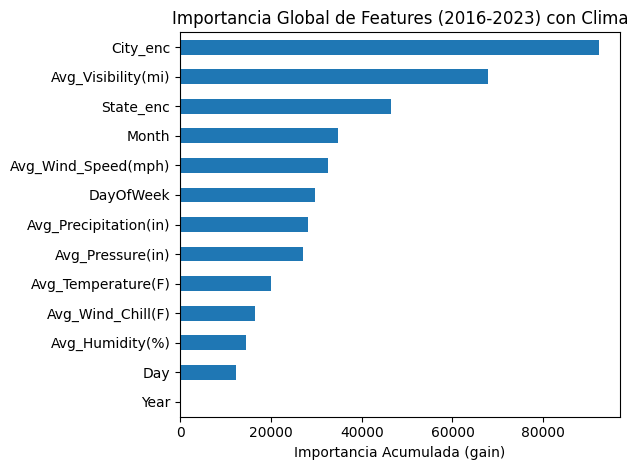

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob

# Cargo todos los años juntos
files = glob.glob("/workspace/ADGE_project/datasets/daily_accidents_*.parquet")
df_list = [pd.read_parquet(f) for f in files]
df = pd.concat(df_list, ignore_index=True)

print(f"Datos cargados: {df.shape}")

# Variables con clima
df_model = df[['Date', 'City', 'State', 'Year', 'Daily_Accidents',
               'Avg_Temperature(F)', 'Avg_Wind_Chill(F)', 'Avg_Humidity(%)',
               'Avg_Pressure(in)', 'Avg_Visibility(mi)', 'Avg_Wind_Speed(mph)',
               'Avg_Precipitation(in)']].copy()

df_model['Date'] = pd.to_datetime(df_model['Date'])

# Features temporales desde 'Date'
df_model['DayOfWeek'] = df_model['Date'].dt.dayofweek
df_model['Month'] = df_model['Date'].dt.month
df_model['Day'] = df_model['Date'].dt.day

# Codificar City y State
le_city = LabelEncoder()
df_model['City_enc'] = le_city.fit_transform(df_model['City'])

le_state = LabelEncoder()
df_model['State_enc'] = le_state.fit_transform(df_model['State'])

# Definir features
feature_cols = ['Year', 'DayOfWeek', 'Month', 'Day', 'City_enc', 'State_enc',
                'Avg_Temperature(F)', 'Avg_Wind_Chill(F)', 'Avg_Humidity(%)',
                'Avg_Pressure(in)', 'Avg_Visibility(mi)', 'Avg_Wind_Speed(mph)',
                'Avg_Precipitation(in)']

# Diccionario para acumular importancias
global_importance = {feat: 0 for feat in feature_cols}

# Iterar por cada año
años = sorted(df_model['Year'].unique())

for año in años:
    print(f"\n=== Año {año} ===")
    
    df_year = df_model[df_model['Year'] == año].copy()
    X = df_year[feature_cols]
    y = df_year['Daily_Accidents']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    # Obtener la importancia de las features como dict
    importancias = model.get_booster().get_score(importance_type='gain')
    
    # Acumular
    for feat, val in importancias.items():
        if feat in global_importance:
            global_importance[feat] += val
        else:
            global_importance[feat] = val  # Por si XGBoost renombra algunas features

# Convertir a DataFrame y ordenar
importance_df = pd.DataFrame.from_dict(global_importance, orient='index', columns=['importance'])
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
importance_df.plot(kind='barh', legend=False)
plt.title("Importancia Global de Features (2016-2023) con Clima")
plt.xlabel("Importancia Acumulada (gain)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Feature importance global sin clima

Datos cargados: (1508616, 12)

=== Año 2016 ===

=== Año 2017 ===

=== Año 2018 ===

=== Año 2019 ===

=== Año 2020 ===

=== Año 2021 ===

=== Año 2022 ===

=== Año 2023 ===


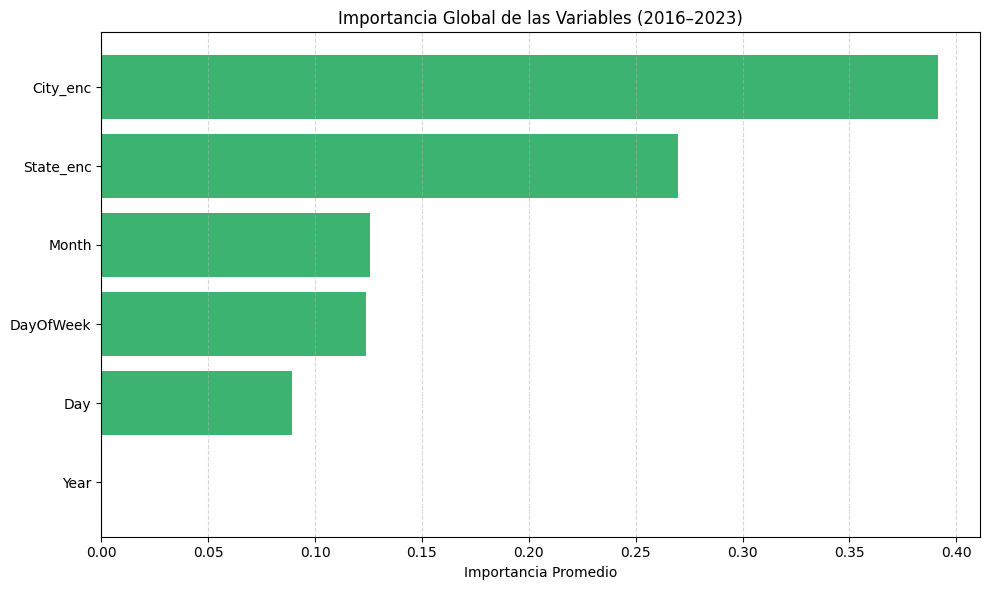

In [30]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob

# Cargar todos los años juntos
files = glob.glob("/workspace/ADGE_project/datasets/daily_accidents_*.parquet")
df_list = [pd.read_parquet(f) for f in files]
df = pd.concat(df_list, ignore_index=True)

print(f"Datos cargados: {df.shape}")

# Variables base (sin clima)
df_model = df[['Date', 'City', 'State', 'Year', 'Daily_Accidents']].copy()
df_model['Date'] = pd.to_datetime(df_model['Date'])
df_model['DayOfWeek'] = df_model['Date'].dt.dayofweek
df_model['Month'] = df_model['Date'].dt.month
df_model['Day'] = df_model['Date'].dt.day

# Codificación
le_city = LabelEncoder()
df_model['City_enc'] = le_city.fit_transform(df_model['City'])

le_state = LabelEncoder()
df_model['State_enc'] = le_state.fit_transform(df_model['State'])

feature_cols = ['Year', 'DayOfWeek', 'Month', 'Day', 'City_enc', 'State_enc']

# Diccionario para acumular importancia
importancia_total = {feature: 0 for feature in feature_cols}

# Entrenar por año y acumular importancia
años = sorted(df_model['Year'].unique())
for año in años:
    print(f"\n=== Año {año} ===")
    df_year = df_model[df_model['Year'] == año].copy()
    X = df_year[feature_cols]
    y = df_year['Daily_Accidents']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    # Extraer importancia
    importancia = model.feature_importances_
    for i, feature in enumerate(feature_cols):
        importancia_total[feature] += importancia[i]

# Convertir a DataFrame
importancia_df = pd.DataFrame.from_dict(importancia_total, orient='index', columns=['ImportanciaTotal'])
importancia_df['ImportanciaPromedio'] = importancia_df['ImportanciaTotal'] / len(años)
importancia_df.sort_values('ImportanciaPromedio', ascending=False, inplace=True)

# Graficar importancia global
plt.figure(figsize=(10,6))
plt.barh(importancia_df.index, importancia_df['ImportanciaPromedio'], color='mediumseagreen')
plt.xlabel("Importancia Promedio")
plt.title("Importancia Global de las Variables (2016–2023)")
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
